# Part 1: Importance Sampling

# Part 2: The Die

We first describe the algebraic relationship in state transitions of the die. Let every state of the die be $n_i$. Then the transition probability for one roll is $p(f_t|n_t) = Uni(A \ \{n_t, 7-n_t\})$. The result is then transformed according to a map $g$:

$$
n_{t+1} = g(n_t, f_t) = 
\begin{cases} 
      n_t & f_t(\mod 4) = 0 \\
      f_t & f_t(\mod 4) = 1 \\
      7 -n_t & f_t(\mod 4) = 2 \\
      7 -n_t & f_t(\mod 4) = 3 \\
   \end{cases}
$$

Let the final state, given current state be represented by r.v. $Y$.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as pl 
import seaborn as sns

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [59]:
def g(n, f):
    return [n, f, 7-n, 7-f][f % 4]

A = np.zeros((6,6))
for i in range(1,7):
    D = set(range(1,7)).difference((i, 7-i))
    for x in [g(i, x) for x in D]:
        A[x-1, i-1] += .25 #column-stochastic matrix
print A

[[ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.    0.25  0.    0.    0.25  0.  ]
 [ 0.    0.    0.    0.5   0.    0.  ]
 [ 0.25  0.25  0.5   0.    0.25  0.25]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.25  0.    0.    0.    0.    0.25]]


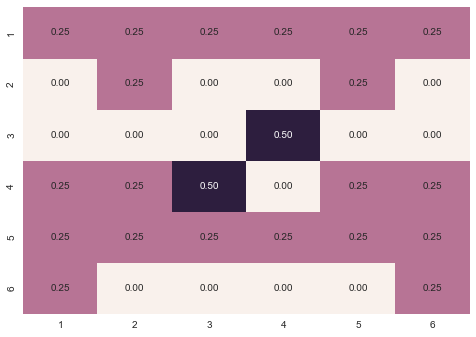

In [3]:
sns.heatmap(A, annot=True, fmt=".2f", xticklabels=range(1,7), yticklabels=range(1,7), cbar=False)

In [4]:
val, v = sp.linalg.eig(A)
v = v[:,np.isclose(val, 1.0)].ravel()
stat =v/ np.sum(v) # the stationary distribution
print stat

[ 0.25        0.08333333  0.11111111  0.22222222  0.25        0.08333333]


Below we carry out the experiments for items (d) and (e) of the question.

[0 1 0 0 0 0]


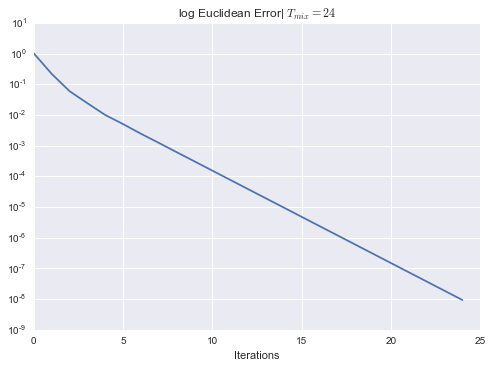

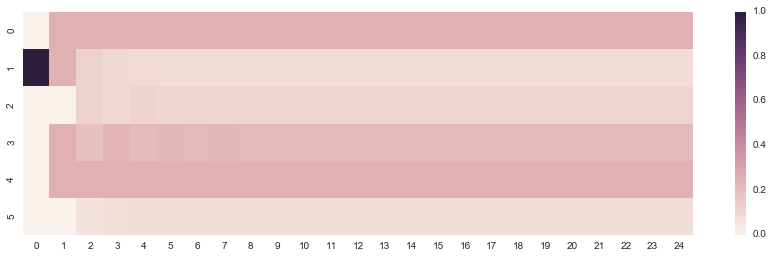

In [50]:
pi = np.random.multinomial(1, [1/6.]*6, size=1).ravel()
print pi
def run_until_mix(pi, A, tol=1e-8):
    err = [np.linalg.norm(pi - stat)]
    mix = np.matrix(pi).T

    while err[-1] > tol:
        pi = A.dot(pi)
        mix = np.c_[mix, np.matrix(pi).T]
        err.append(np.linalg.norm(pi - stat))
        
    return pi, err, mix

pi,err,mix = run_until_mix(pi, A)

pl.yscale("log")
pl.title("log Euclidean Error" + "| $T_{mix} = %d$" % (len(err)-1))
pl.xlabel("Iterations")
pl.plot(err)
pl.show()

#pl.imshow(mix, interpolation="none")
f = pl.figure(figsize=(15,4))
sns.heatmap(mix)

There appears to be a slight problem with item d however. Note that for different start states, the mixing time is different. We demonstrate below. For the remainder of the problem, we will work with $T_{mix} = 27$ to be on the safe side.

In [60]:
def ket(i, n):
    a = np.zeros(n)
    a[i] = 1
    return a

exp = np.zeros((6,10))
for i in range(6):
    for j in range(10):
        _, err, _a = run_until_mix(ket(i, 6), A)
        exp[i,j] = len(err)-1
        
print exp

[[ 24.  24.  24.  24.  24.  24.  24.  24.  24.  24.]
 [ 24.  24.  24.  24.  24.  24.  24.  24.  24.  24.]
 [ 26.  26.  26.  26.  26.  26.  26.  26.  26.  26.]
 [ 27.  27.  27.  27.  27.  27.  27.  27.  27.  27.]
 [ 24.  24.  24.  24.  24.  24.  24.  24.  24.  24.]
 [ 24.  24.  24.  24.  24.  24.  24.  24.  24.  24.]]


For the rest of the question. We re-implement the chain without the bells and whistles. We also add the functionality to draw a sample. 

In [174]:
def sample_run(st, A, N=27):
    arr = []
    for i in range(N):
        arr.append(st)
        st = np.random.choice(range(6), p=A.dot(ket(st,6))) # advance the chain one step
    return st

(array([ 256.,    0.,   90.,    0.,  116.,    0.,  200.,    0.,  260.,   78.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

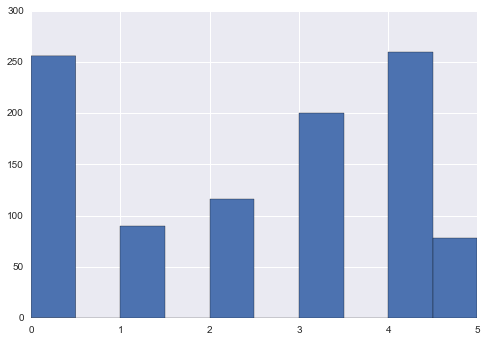

In [212]:
# draw 1000 independent samples and plot
samples = []
for i in range(1000):
    samples.append(sample_run(1, A))
    
pl.hist(samples)